In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 3. Part 1
## 3.1 Classification and regression with a two-layer perceptron
### 3.1.1 Classification of linearly non-separable data

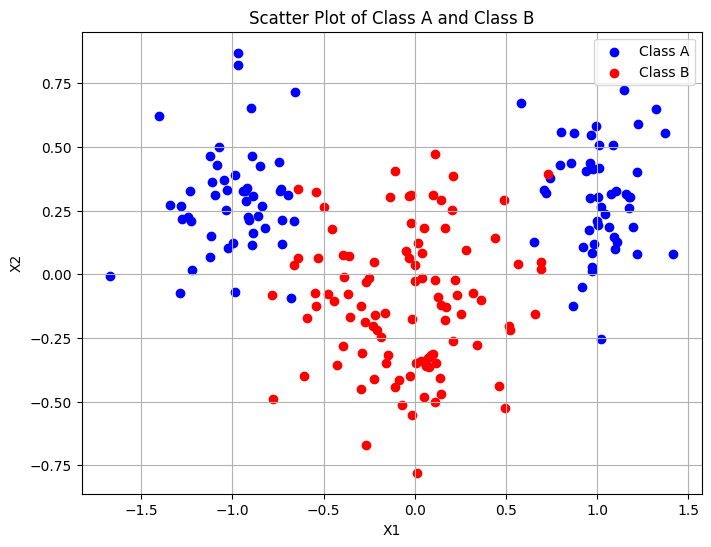

In [2]:
# generate non-separable data
ndata = 100
mA = [1.0, 0.3]
sigmaA = 0.2
mB = [0.0, -0.1]
sigmaB = 0.3

classA = np.zeros((2, ndata))
classA[0, :int(0.5*ndata)] = np.random.randn(int(0.5*ndata)) * sigmaA - mA[0]
classA[0, int(0.5*ndata):] = np.random.randn(int(0.5*ndata)) * sigmaA + mA[0]
classA[1, :] = np.random.randn(ndata) * sigmaA + mA[1]

classB = np.zeros((2, ndata))
classB[0, :] = np.random.randn(ndata) * sigmaB + mB[0]
classB[1, :] = np.random.randn(ndata) * sigmaB + mB[1]

# shuffle both
shuffled_indices = np.random.permutation(ndata)
classA = classA[:, shuffled_indices]
classB = classB[:, shuffled_indices]

# plot
plt.figure(figsize=(8, 6))
plt.scatter(classA[0, :], classA[1, :], color='blue', label='Class A')
plt.scatter(classB[0, :], classB[1, :], color='red', label='Class B')

plt.title('Scatter Plot of Class A and Class B')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
# function for pre-processing data: create pattern and target

def preprocess_data(classA, classB, bias=True):

  len_classA = classA.shape[1]
  len_classB = classB.shape[1]

  # create target values
  targetA = -1 * np.ones((1, len_classA))  # label as -1
  targetB = np.ones((1, len_classB))       # label as 1

  if bias == True:
    # add bias to the data
    biasA = np.ones((1, len_classA))
    biasB = np.ones((1, len_classA))
    patternA = np.vstack((classA, biasA, targetA))
    patternB = np.vstack((classB, biasB, targetB))

  else:
    patternA = np.vstack((classA, targetA))
    patternB = np.vstack((classB, targetB))

  # shuffle the two classes and their respective targets
  pattern = np.hstack((patternA, patternB))
  shuffled_indices = np.random.permutation(pattern.shape[1])
  pattern = pattern[:, shuffled_indices]
  target = pattern[-1, :].reshape(1,-1)
  pattern = np.delete(pattern, -1, axis=0)

  return pattern, target


# pre-process data
pattern, target = preprocess_data(classA, classB, False) #don't add bias, backprob will take care of that

In [10]:
# performance functions
def calculate_accuracy(predictions, true_labels):
    correct_predictions = np.sum(predictions == true_labels)
    accuracy = correct_predictions / true_labels.shape[1]
    return accuracy

def calculate_mse(predictions, true_labels):
    mse = np.mean((predictions - true_labels) ** 2)
    return mse

In [5]:
# backpropagation algorithm: integrated testing on training and validation set

def backprop(input_neurons, hidden_neurons, output_neurons, pattern_train, target_train, pattern_val = None, target_val = None, lr=0.001, epochs=200, alpha=0.9):
    # Initialize w, v, dw, dv
    w = np.random.randn(hidden_neurons, input_neurons + 1)    # Weights for hidden layer (+1 for bias)
    v = np.random.randn(output_neurons, hidden_neurons + 1)   # Weights for output layer (+1 for bias)

    dw = np.zeros_like(w)  # Weight change matrix for hidden layer (matching w)
    dv = np.zeros_like(v)  # Weight change matrix for output layer (matching v)

    ndata = pattern_train.shape[1]  # Number of data points (columns in patterns)

    # define learning curve metrics
    accuracies_train = []
    mses_train = []
    accuracies_val = []
    mses_val = []


    for epoch in range(epochs):
        # Forward pass
        hin = np.dot(w, np.vstack([pattern_train, np.ones((1, ndata))]))          # Adding bias to input patterns
        hout = np.vstack([2 / (1 + np.exp(-hin)) - 1, np.ones((1, ndata))])  # Hidden layer output with bias

        oin = np.dot(v, hout)
        out = 2 / (1 + np.exp(-oin)) - 1

        # Backward pass
        delta_o = (out - target_train) * ((1 + out) * (1 - out)) * 0.5         # Output layer delta
        delta_h = np.dot(v.T, delta_o) * ((1 + hout) * (1 - hout)) * 0.5  # Hidden layer delta
        delta_h = delta_h[:hidden_neurons, :]  # Exclude the bias row from delta_h

        # Weight updates
        dw = (dw * alpha) - np.dot(delta_h, np.vstack([pattern_train, np.ones((1, ndata))]).T) * (1 - alpha)
        dv = (dv * alpha) - np.dot(delta_o, hout.T) * (1 - alpha)

        # Update the weights using the learning rate
        w += dw * lr
        v += dv * lr

        # test
        accuracy_train, mse_train = test_backprop(pattern_train, target_train, w, v)
        accuracies_train.append(accuracy_train)
        mses_train.append(mse_train)

        if pattern_val is not None and target_val is not None:
            accuracy_val, mse_val = test_backprop(pattern_val, target_val, w, v)
            accuracies_val.append(accuracy_val)
            mses_val.append(mse_val)


    return w, v, accuracies_train, mses_train, accuracies_val, mses_val


In [9]:
def test_backprop(patterns, targets, w, v, classification = True):
  ndata = patterns.shape[1]  # Number of data points (columns in patterns)

  hin = np.dot(w, np.vstack([patterns, np.ones((1, ndata))]))          # Adding bias to input patterns
  hout = np.vstack([2 / (1 + np.exp(-hin)) - 1, np.ones((1, ndata))])  # Hidden layer output with bias
  oin = np.dot(v, hout)
  out = 2 / (1 + np.exp(-oin)) - 1

  # calulate mse
  mse = calculate_mse(out, targets)

  if classification == True:
    # calculate accuracy
    accuracy = calculate_accuracy(np.sign(out), targets)
  else:
    accuracy = None
  return accuracy, mse

3.1.1.1 Classification with 100% of data available for training

In [7]:
_, _, accuracyA, mseA, _, _ = backprop(2, 2, 1, pattern, target)
_, _, accuracyB, mseB, _, _ = backprop(2, 7, 1, pattern, target)
_, _, accuracyC, mseC, _, _ = backprop(2, 12, 1, pattern, target)

In [8]:
def plot_metrics(acc1, mse1, label1, acc2, mse2, label2, acc3 = None, mse3 = None, label3 = None):
    # Ensure inputs are NumPy arrays
    acc1 = np.array(acc1)
    mse1 = np.array(mse1)
    acc2 = np.array(acc2)
    mse2 = np.array(mse2)
    if acc3 is not None:
      acc3 = np.array(acc3)
      mse3 = np.array(mse3)

  # Create x-axis values
    epochs = np.linspace(1, len(acc1), len(acc1))

    # Create subplots: 1 row, 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot Accuracy on the first subplot
    ax1.plot(epochs, acc1, label=label1, color='r')
    ax1.plot(epochs, acc2, label=label2, color='g')
    if acc3 is not None:
      ax1.plot(epochs, acc3, label=label3, color='b')
    ax1.set_xlim(1,200)
    ax1.set_ylim(0,1)
    ax1.set_title('Accuracy', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.set_ylabel('Accuracy', fontsize=14)
    ax1.grid(True)
    ax1.legend(loc='best', fontsize=12)

    # Plot MSE on the second subplot
    ax2.plot(epochs, mse1, label=label1, color='r')
    ax2.plot(epochs, mse2, label=label2, color='g')
    if acc3 is not None:
      ax2.plot(epochs, mse3, label=label3, color='b')
    ax2.set_xlim(1,200)
    ax2.set_ylim(0,3.5)
    ax2.set_title('Mean Squared Error (MSE)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=14)
    ax2.set_ylabel('MSE', fontsize=14)
    ax2.grid(True)
    ax2.legend(loc='best', fontsize=12)

    # Add a main title for the whole figure
    fig.suptitle('Performance Comparison', fontsize=18)

    # Show the plot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the title
    plt.show()



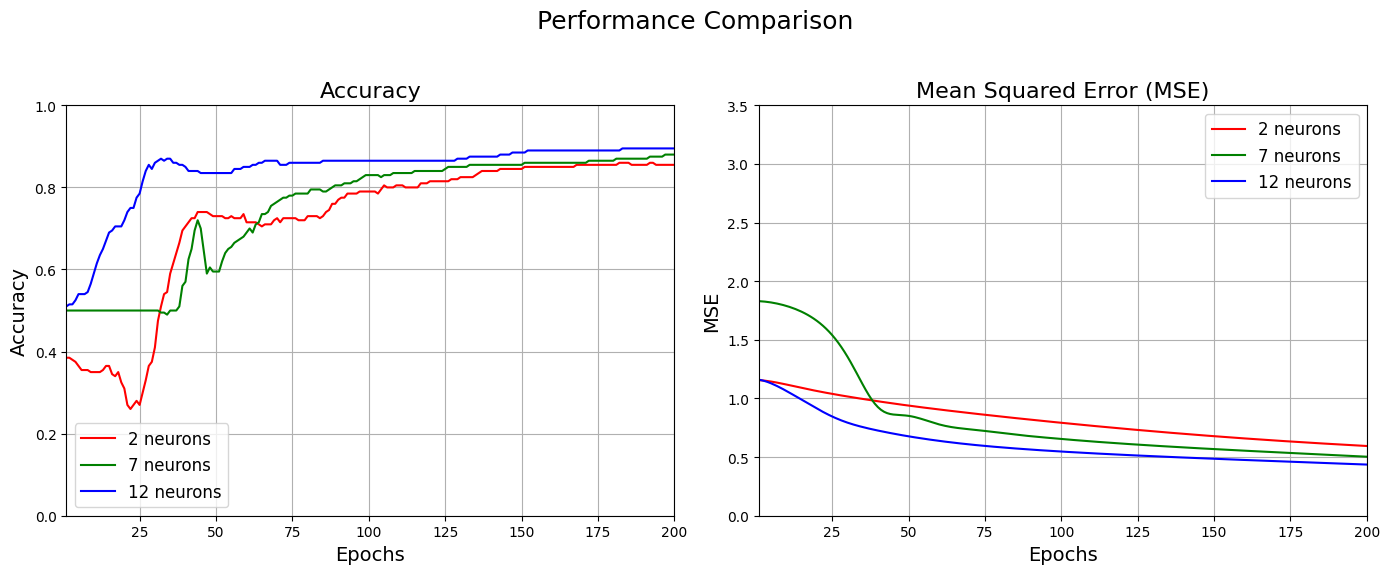

In [9]:
plot_metrics(accuracyA, mseA, '2 neurons', accuracyB, mseB, '7 neurons', accuracyC, mseC, '12 neurons')



3.1.1.2 Classification with validation set


In [10]:
def split_data(classA, classB, ratioA=0.2, ratioB=0.2):

  len_classA = classA.shape[1]
  len_classB = classB.shape[1]

  classA_train = classA[:, :int((1-ratioA)*len_classA)]
  classA_val = classA[:, int((1-ratioA)*len_classA):]

  classB_train = classB[:, :int((1-ratioB)*len_classB)]
  classB_val = classB[:, int((1-ratioB)*len_classB):]

  return classA_train, classA_val, classB_train, classB_val

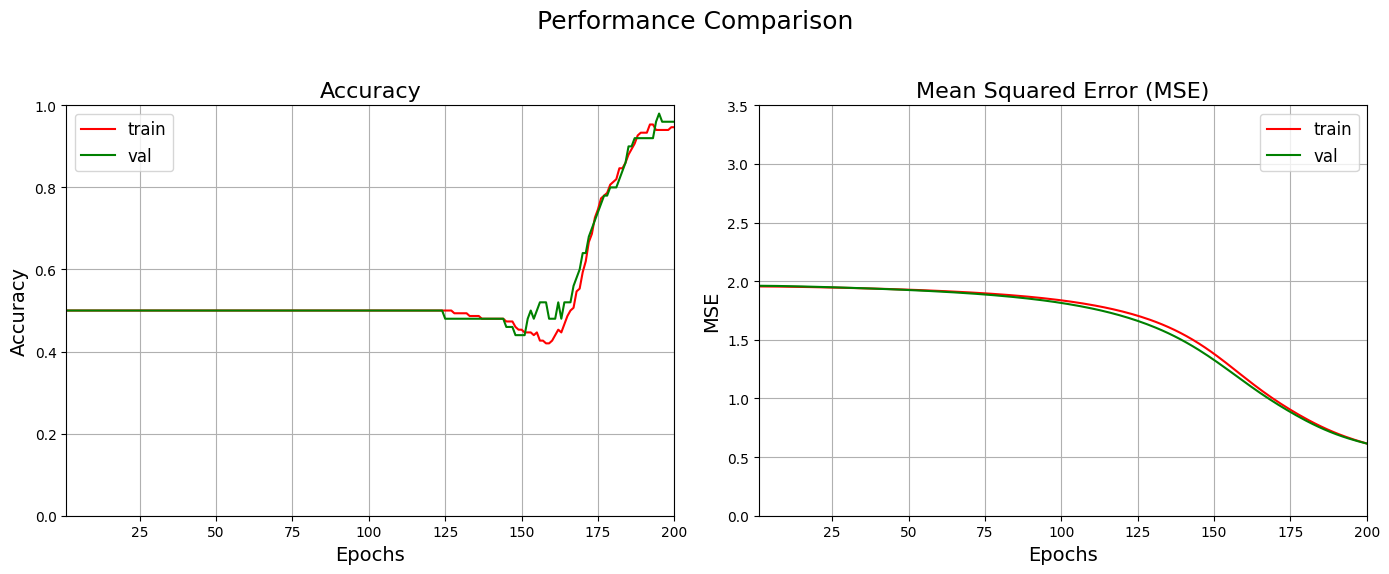

In [11]:
# A: validation with 25% of both

classA_trainA, classA_valA, classB_trainA, classB_valA = split_data(classA, classB, 0.25, 0.25)
pattern_trainA, target_trainA = preprocess_data(classA_trainA, classB_trainA, False)
pattern_valA, target_valA = preprocess_data(classA_valA, classB_valA, False)

_, _, accuracy_trainA, mse_trainA, accuracy_valA, mse_valA = backprop(2, 12, 1, pattern_trainA, target_trainA, pattern_valA, target_valA)

plot_metrics(accuracy_trainA, mse_trainA, 'train', accuracy_valA, mse_valA, 'val')

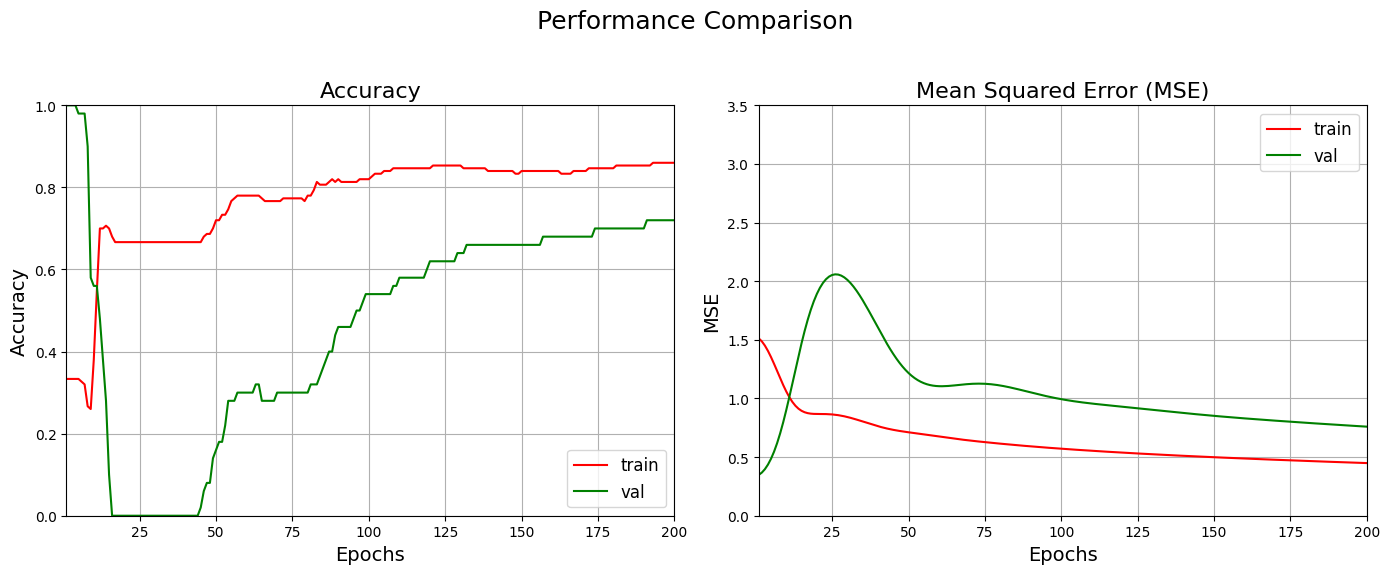

In [12]:
# B: validation with 50% of class A

classA_trainB, classA_valB, classB_trainB, classB_valB = split_data(classA, classB, 0.5, 0)

pattern_trainB, target_trainB = preprocess_data(classA_trainB, classB_trainB, False)
pattern_valB, target_valB = preprocess_data(classA_valB, classB_valB, False)

_, _, accuracy_trainB, mse_trainB, accuracy_valB, mse_valB = backprop(2, 12, 1, pattern_trainB, target_trainB, pattern_valB, target_valB)

plot_metrics(accuracy_trainB, mse_trainB, 'train', accuracy_valB, mse_valB, 'val')


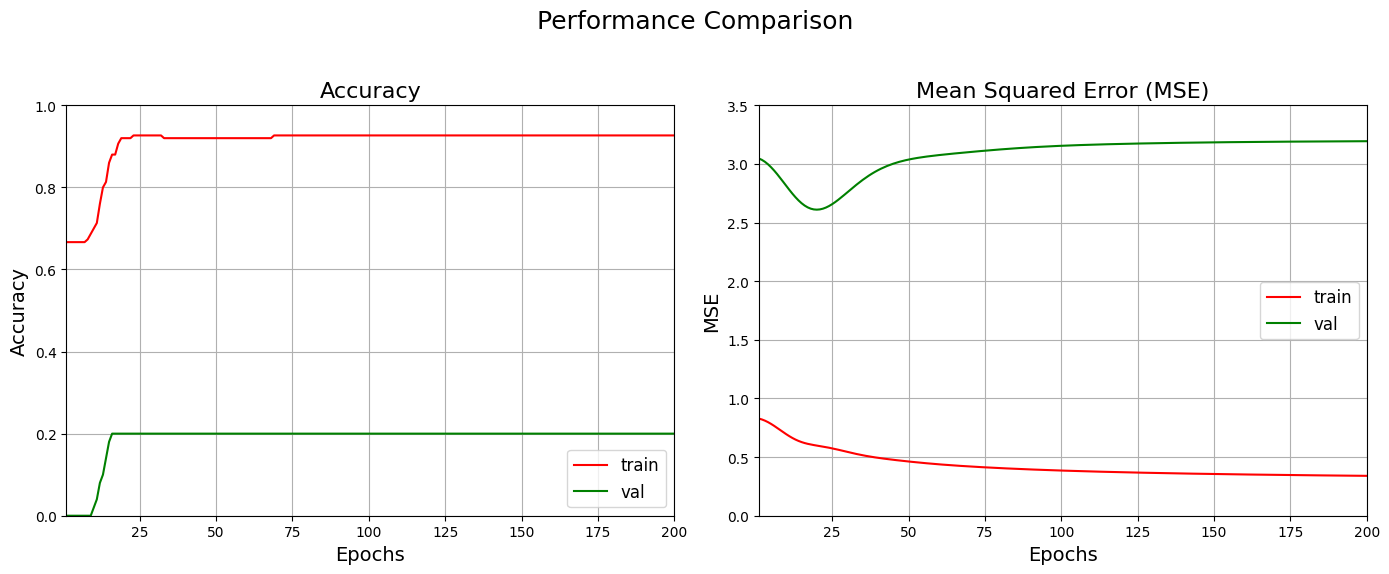

In [13]:
# C: Validation with 20% of A<0 and 80% A>0

ndataAa = 10 # Removed 80% of subset A > 0
ndataAb = 40 # Removed 20% of subset A < 0
ndataA = ndataAa + ndataAb
ndataB = 100

classA_trainC = np.zeros((2, ndataA))
classA_trainC[0, :round(ndataAa)] = np.random.randn(int((ndataAa))) * sigmaA + mA[0]
classA_trainC[0, round(ndataAa):] = np.random.randn(int((ndataAb))) * sigmaA - mA[0]
classA_trainC[1, :] = np.random.randn(ndataA) * sigmaA + mA[1]

classB_trainC = np.zeros((2, ndataB))
classB_trainC[0, :] = np.random.randn(ndataB) * sigmaB + mB[0]
classB_trainC[1, :] = np.random.randn(ndataB) * sigmaB + mB[1]

classA_valC = np.zeros((2, ndataA))
classA_valC[0, :round(ndataAb)] = np.random.randn(int((ndataAb))) * sigmaA + mA[0]
classA_valC[0, round(ndataAb):] = np.random.randn(int((ndataAa))) * sigmaA - mA[0]
classA_valC[1, :] = np.random.randn(ndataA) * sigmaA + mA[1]

pattern_trainC, target_trainC = preprocess_data(classA_trainC, classB_trainC, False)
target_valC = -1 * np.ones((1, ndataA))  # label as -1
shuffled_indices = np.random.permutation(classA_valC.shape[1])
pattern_valC = classA_valC[:, shuffled_indices]

_, _, accuracy_trainC, mse_trainC, accuracy_valC, mse_valC = backprop(2, 12, 1, pattern_trainC, target_trainC, pattern_valC, target_valC)

plot_metrics(accuracy_trainC, mse_trainC, 'train', accuracy_valC, mse_valC, 'val')

In [58]:
# functions to classify data and plot estimated decision boundary

def classify_data(w, v, patterns):
  ndata = patterns.shape[1]  # Number of data points (columns in patterns)

  hin = np.dot(w, np.vstack([patterns, np.ones((1, ndata))]))          # Adding bias to input patterns
  hout = np.vstack([2 / (1 + np.exp(-hin)) - 1, np.ones((1, ndata))])  # Hidden layer output with bias
  oin = np.dot(v, hout)
  out = 2 / (1 + np.exp(-oin)) - 1

  predictions = np.sign(out)
  data = np.vstack([patterns, predictions])
  return data


def plot_classified_data(classified_data):
  plt.figure(figsize=(8, 6))

  for n in range(classified_data.shape[1]):
    if classified_data[2, n] == 1:
      plt.scatter(classified_data[0, n], classified_data[1, n], color='red')
    else:
      plt.scatter(classified_data[0, n], classified_data[1, n], color='blue')

  plt.title('Estimated decision boundary')
  plt.xlabel('X1')
  plt.ylabel('X2')
  plt.grid(True)
  plt.show()

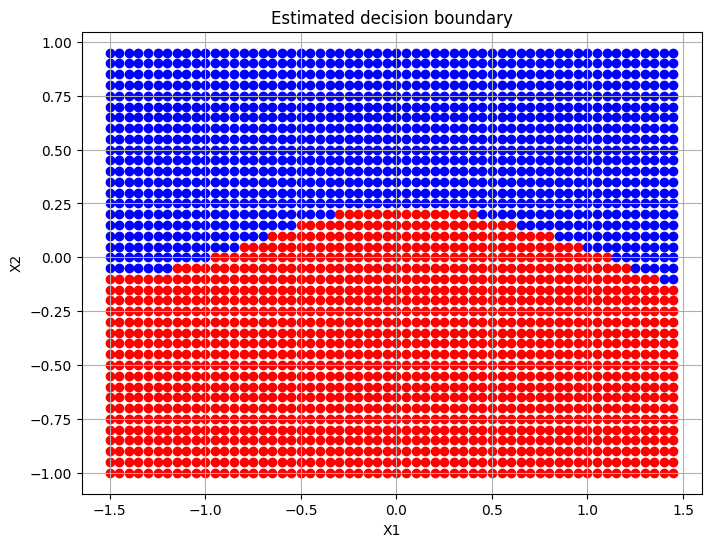

In [59]:
# Attempt to find decision boundary

# create many data points
nhorizontal = 60
nvertical = 40
ndata = nhorizontal * nvertical

stepsize = 0.5/10

# create the data
classC = np.zeros((2, ndata))
for i in range(nhorizontal):
  for j in range(nvertical):
    classC[0, i*nvertical + j] = -1.5+stepsize*i
    classC[1, i*nvertical + j] = -1.0+stepsize*j


w, v, _, _, _, _= backprop(2, 12, 1, pattern, target)
classified_C = classify_data(w, v, classC)
plot_classified_data(classified_C)

### 3.1.3 Function approximation

Train and visualize

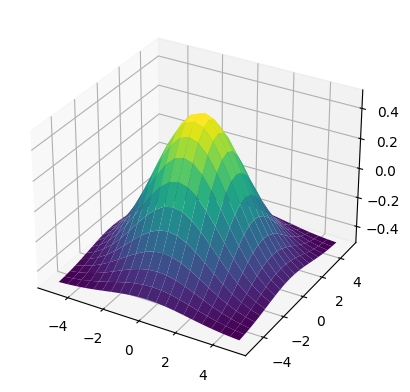

In [5]:
# generate data, generate plot

from mpl_toolkits.mplot3d import Axes3D

x = np.arange(-5, 5.5, 0.5)
y = np.arange(-5, 5.5, 0.5)
X, Y = np.meshgrid(x, y)
Z = np.exp(-X**2 * 0.1) * np.exp(-Y**2 * 0.1) - 0.5

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
plt.show()


In [6]:
ndata = X.size
targets_mesh = Z.reshape(1, ndata)
patterns_mesh = np.vstack((X.reshape(1, ndata), Y.reshape(1, ndata)))

In [7]:
def backprob_approx_func(input_neurons, hidden_neurons, output_neurons, pattern_train, target_train, pattern_val = None, target_val = None, lr=0.001, epochs=200, alpha=0.9, plot=True):
  # Initialize w, v, dw, dv
  w = np.random.randn(hidden_neurons, input_neurons + 1)    # Weights for hidden layer (+1 for bias)
  v = np.random.randn(output_neurons, hidden_neurons + 1)   # Weights for output layer (+1 for bias)

  dw = np.zeros_like(w)  # Weight change matrix for hidden layer (matching w)
  dv = np.zeros_like(v)  # Weight change matrix for output layer (matching v)

  ndata = pattern_train.shape[1]  # Number of data points (columns in patterns)

  mses = []


  for epoch in range(epochs):
    # Forward pass
    hin = np.dot(w, np.vstack([pattern_train, np.ones((1, ndata))]))          # Adding bias to input patterns
    hout = np.vstack([2 / (1 + np.exp(-hin)) - 1, np.ones((1, ndata))])  # Hidden layer output with bias

    oin = np.dot(v, hout)
    out = 2 / (1 + np.exp(-oin)) - 1

    # Backward pass
    delta_o = (out - target_train) * ((1 + out) * (1 - out)) * 0.5         # Output layer delta
    delta_h = np.dot(v.T, delta_o) * ((1 + hout) * (1 - hout)) * 0.5  # Hidden layer delta
    delta_h = delta_h[:hidden_neurons, :]  # Exclude the bias row from delta_h

    # Weight updates
    dw = (dw * alpha) - np.dot(delta_h, np.vstack([pattern_train, np.ones((1, ndata))]).T) * (1 - alpha)
    dv = (dv * alpha) - np.dot(delta_o, hout.T) * (1 - alpha)

    # Update the weights using the learning rate
    w += dw * lr
    v += dv * lr

    # Test error
    if pattern_val is not None:
      pattern = np.hstack([pattern_train, pattern_val])
      target = np.hstack([target_train, target_val])
    else:
      pattern = pattern_train
      target = target_train

    _, mse = test_backprop(pattern, target, w, v)
    mses.append(mse)

  if plot == True:
    # generate plot based on the last iteration
    gridsize = int(np.sqrt(ndata))  # gridsize is the number of elements along one axis
    X, Y = np.meshgrid(np.linspace(-5, 5, gridsize), np.linspace(-5, 5, gridsize))

    # create plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    Z = out.reshape(gridsize, gridsize) # Reshape 'out' into a 2D array
    ax.plot_surface(X, Y, Z, cmap='viridis')  # Replot with updated Z values
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    ax.set_zlim([-0.7, 0.7])

    plt.show()

  return w, v, mses

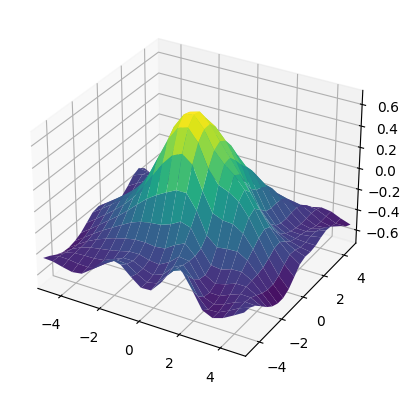

In [16]:
w, v, mses = backprob_approx_func(2, 70, 1, patterns_mesh, targets_mesh)

Evaluate generalisation performance

3.1.3.1: Varying the number of nodes in the hidden layer

In [17]:
def plot_mses(mses, labels):
  # Create x-axis values
  epochs = np.linspace(1, mses.shape[1], mses.shape[1])
  nr_models = mses.shape[0]

  plt.figure(figsize=(8, 6))
  plt.xlim(1,200)
  plt.ylim(0,1.0)
  plt.title('MSEs', fontsize=16)
  plt.xlabel('Epochs', fontsize=14)
  plt.grid(True)

  for i in range(nr_models):
    plt.plot(epochs, mses[i, :], label=labels[i])

  plt.legend(loc='best', fontsize=12)
  plt.show()

In [18]:
def split_mesh_data(patterns, targets, ratio=0.2):
  shuffled_indices = np.random.permutation(ndata)
  patterns = patterns[:, shuffled_indices]
  targets = targets[:, shuffled_indices]
  pattern_train = patterns[:, :int((1-ratio)*ndata)]
  pattern_val = patterns[:, int((1-ratio)*ndata):]
  target_train = targets[:, :int((1-ratio)*ndata)]
  target_val = targets[:, int((1-ratio)*ndata):]
  return pattern_train, pattern_val, target_train, target_val

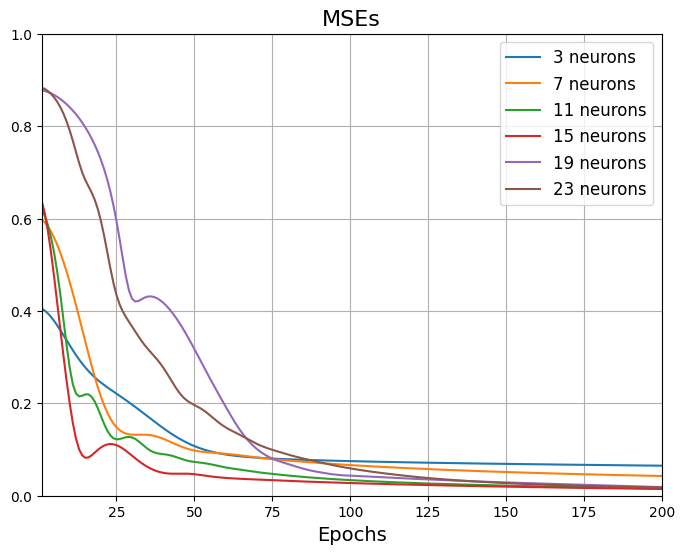

In [20]:
nr_epochs = 200
mses = np.zeros((6, nr_epochs))

pattern_train_mesh, pattern_val_mesh, target_train_mesh, target_val_mesh = split_mesh_data(patterns_mesh, targets_mesh)

for i in range(0,6):
  _, _, mse = backprob_approx_func(2, 3+i*4, 1, pattern_train = pattern_train_mesh, target_train= target_train_mesh, pattern_val=pattern_val_mesh, target_val= target_val_mesh, plot=False)
  mses[i,:] = mse

# plot
plot_mses(mses, ['3 neurons', '7 neurons', '11 neurons', '15 neurons', '19 neurons', '23 neurons'])

best_model_neurons = 15
# Which one performs best? --> varies every time

3.1.3.2: Varying split of validation and training set

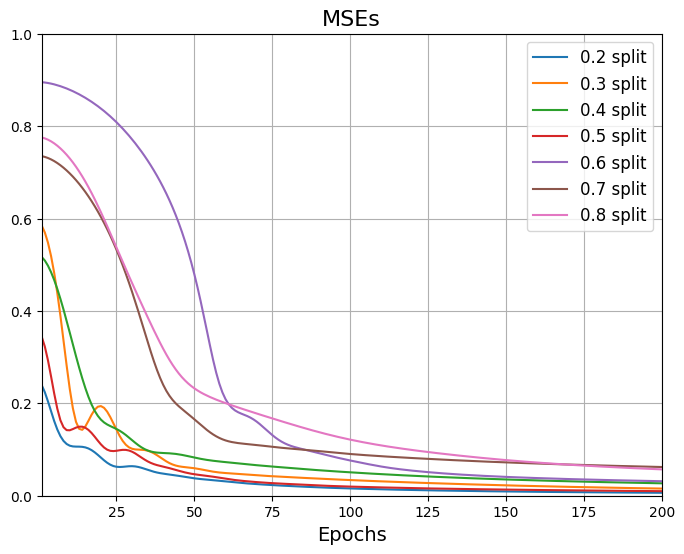

In [67]:
mses = np.zeros((7, nr_epochs))
for i in range(0,7):
  pattern_train_mesh, pattern_val_mesh, target_train_mesh, target_val_mesh = split_mesh_data(patterns_mesh, targets_mesh, 0.2+i*0.1)
  _, _, mse = backprob_approx_func(2, best_model_neurons, 1, pattern_train = pattern_train_mesh, target_train= target_train_mesh, pattern_val=pattern_val_mesh, target_val= target_val_mesh, plot=False)
  mses[i,:] = mse


plot_mses(mses, ['0.2 split', '0.3 split', '0.4 split', '0.5 split', '0.6 split', '0.7 split', '0.8 split'])

best_model_split = 0.2


3.1.3.3: Speeding up convergence

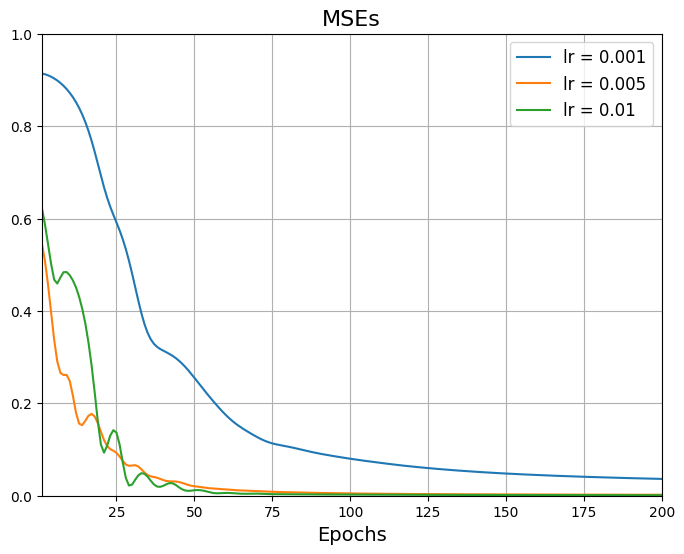

In [69]:
mses = np.zeros((3, nr_epochs))
lrs = [0.001, 0.005, 0.01]
for i in range(0,3):
  pattern_train_mesh, pattern_val_mesh, target_train_mesh, target_val_mesh = split_mesh_data(patterns_mesh, targets_mesh, best_model_split)
  _, _, mse = backprob_approx_func(2, best_model_neurons, 1, pattern_train = pattern_train_mesh, target_train= target_train_mesh, pattern_val=pattern_val_mesh, target_val= target_val_mesh, lr =lrs[i], plot=False)
  mses[i,:] = mse


plot_mses(mses, ['lr = 0.001', 'lr = 0.005', 'lr = 0.01'])